In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from wordcloud import WordCloud
import warnings
import nltk

warnings.filterwarnings(action = 'ignore')

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pinil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
eng_swords = list(stopwords.words('english'))
print(eng_swords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [3]:
df = pd.read_csv("../Data/FakeNewsNet.csv")

In [4]:
df.head()

title  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   

                                            news_url        source_domain  \
0  http://toofab.com/2017/05/08/real-housewives-a...           toofab.com   
1  https://www.today.com/style/see-people-s-choic...        www.today.com   
2  https://www.etonline.com/news/220806_sophia_bu...     www.etonline.com   
3  https://www.dailymail.co.uk/news/article-33655...  www.dailymail.co.uk   
4  https://www.zerchoo.com/entertainment/gossip-g...      www.zerchoo.com   

   tweet_num  real  
0         42     1  
1          0     1  
2         63     1  
3         20     1  
4         38     1

In [5]:
df.shape

(23196, 5)

There are 23,196 rows and 5 columns in that dataset.

title: title of the article.

news_url: URL of the article.

source domain: web domain where article was posted.

tweet_num: number of retweets for this article.

real: label column, where 1 is real and 0 is fake.

# Dealing with duplicate values.

In [6]:
df.duplicated().sum()

137

There are 137 duplicate values in that dataset.

In [7]:
df.drop_duplicates(inplace = True)

# Dealing with null values.

In [8]:
df.isnull().sum()

title              0
news_url         329
source_domain    329
tweet_num          0
real               0
dtype: int64

There are some missing values in that dataset.

In [9]:
df.fillna(' ', inplace = True)

In [10]:
df.drop(columns = ['news_url', 'tweet_num'], axis = 1, inplace = True)

In [11]:
df.isnull().sum()

title            0
source_domain    0
real             0
dtype: int64

In [12]:
df.shape

(23059, 3)

Now it has 23,059 rows and 3 columns.

In [13]:
list(df.columns)

['title', 'source_domain', 'real']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23059 entries, 0 to 23195
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23059 non-null  object
 1   source_domain  23059 non-null  object
 2   real           23059 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 720.6+ KB


In [15]:
df['concat'] = df['title'] + ' ' + df['source_domain']
df.head(3)

title     source_domain  real  \
0  Kandi Burruss Explodes Over Rape Accusation on...        toofab.com     1   
1  People's Choice Awards 2018: The best red carp...     www.today.com     1   
2  Sophia Bush Sends Sweet Birthday Message to 'O...  www.etonline.com     1   

                                              concat  
0  Kandi Burruss Explodes Over Rape Accusation on...  
1  People's Choice Awards 2018: The best red carp...  
2  Sophia Bush Sends Sweet Birthday Message to 'O...

In [16]:
ps = PorterStemmer()

In [28]:
def func(x):
    x = re.sub(r'[^\w\s]', ' ', x)
    x = x.lower()
    x = x.split() 
    x = [ps.stem(i) for i in x if not i in eng_swords]
    x = ' '.join(x)
    
    return x

In [29]:
df['new_concat'] = df['concat'].apply(func)

In [30]:
df.head()

title        source_domain  \
0  Kandi Burruss Explodes Over Rape Accusation on...           toofab.com   
1  People's Choice Awards 2018: The best red carp...        www.today.com   
2  Sophia Bush Sends Sweet Birthday Message to 'O...     www.etonline.com   
3  Colombian singer Maluma sparks rumours of inap...  www.dailymail.co.uk   
4  Gossip Girl 10 Years Later: How Upper East Sid...      www.zerchoo.com   

   real                                             concat  \
0     1  Kandi Burruss Explodes Over Rape Accusation on...   
1     1  People's Choice Awards 2018: The best red carp...   
2     1  Sophia Bush Sends Sweet Birthday Message to 'O...   
3     1  Colombian singer Maluma sparks rumours of inap...   
4     1  Gossip Girl 10 Years Later: How Upper East Sid...   

                                          new_concat  
0  kandi burruss explod rape accus real housew at...  
1  peopl choic award 2018 best red carpet look ww...  
2  sophia bush send sweet birthday messag one tre...  
3  colombian singer maluma spark rumour inappropr...  
4  gossip girl 10 year later upper east sider sho...

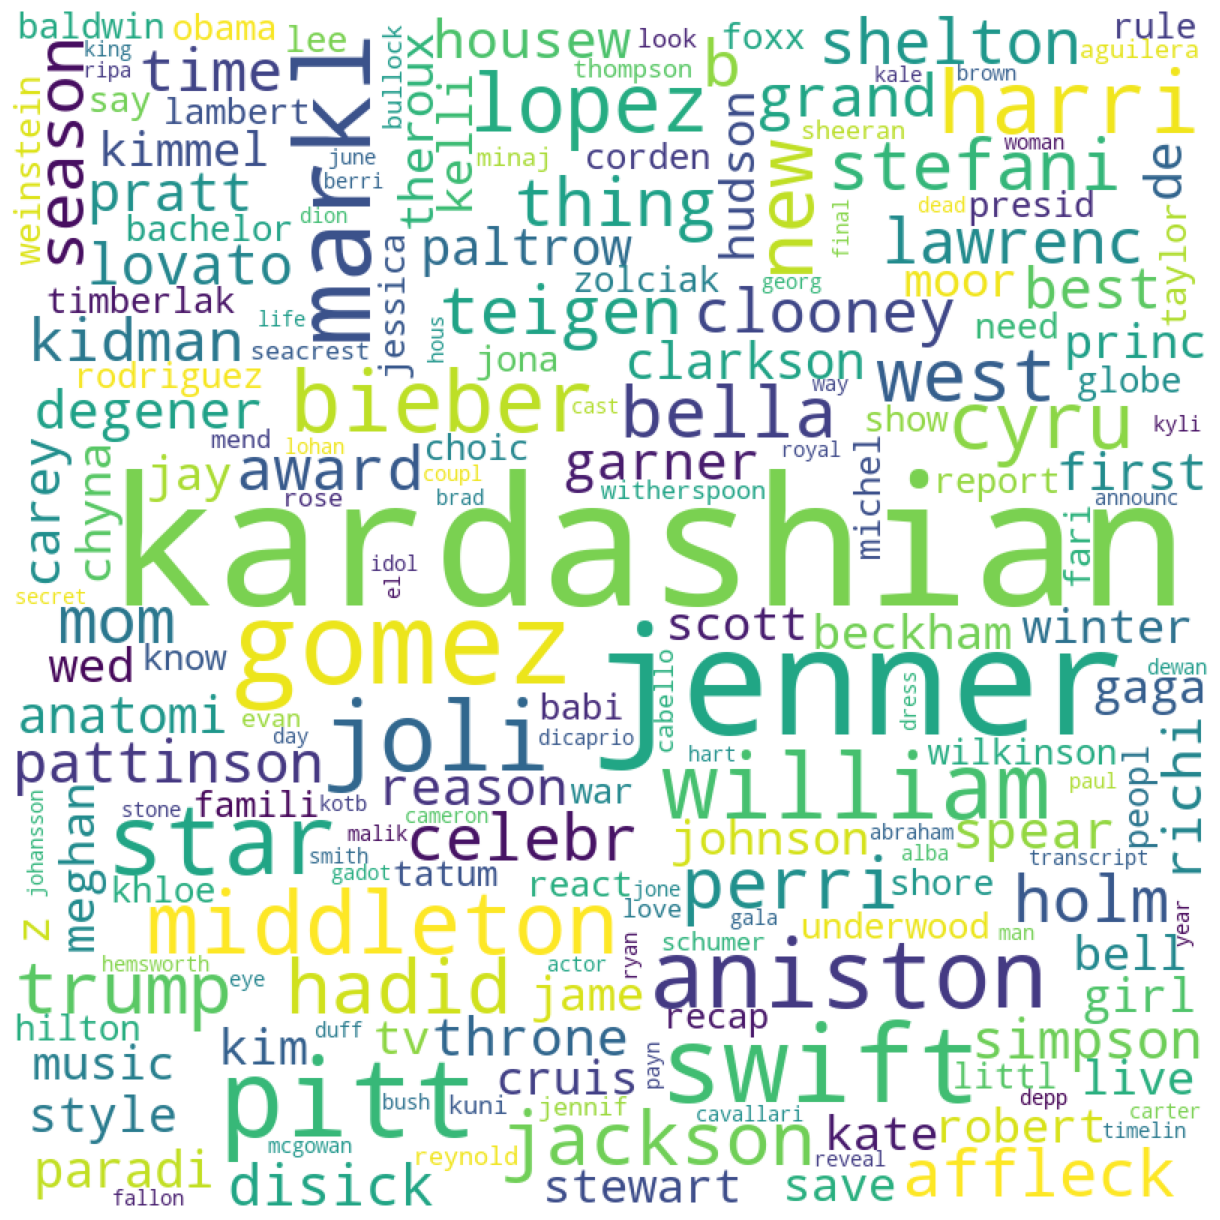

In [84]:
text = " ".join(cat.split()[1] for cat in df['new_concat'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(text)
 
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [31]:
df.replace({'real' : {1 : 'R', 0 : 'F'}}, inplace = True) 

R --> Real

F --> Fake

In [79]:
x = df['new_concat']
y = df['real']

In [80]:
x.head()

0    kandi burruss explod rape accus real housew at...
1    peopl choic award 2018 best red carpet look ww...
2    sophia bush send sweet birthday messag one tre...
3    colombian singer maluma spark rumour inappropr...
4    gossip girl 10 year later upper east sider sho...
Name: new_concat, dtype: object

In [81]:
y.head()

0    R
1    R
2    R
3    R
4    R
Name: real, dtype: object

In [82]:
vc = TfidfVectorizer()
vc.fit(x)

TfidfVectorizer()

In [83]:
x = vc.transform(x)
print(x)

  (0, 14226)	0.2109210916012417
  (0, 13518)	0.29440387772248655
  (0, 11092)	0.2565266031320018
  (0, 10796)	0.23132778043076685
  (0, 10741)	0.3018883388948728
  (0, 7147)	0.3872188543824673
  (0, 6388)	0.2609785811690195
  (0, 4669)	0.35478843756643996
  (0, 2922)	0.05081702443840068
  (0, 2161)	0.3872188543824673
  (0, 1092)	0.30710528609163623
  (0, 497)	0.26005014183606956
  (1, 14825)	0.09763146531825517
  (1, 13484)	0.3526452503537675
  (1, 10868)	0.3609259326989961
  (1, 9990)	0.22681664592562104
  (1, 7936)	0.3184952169993068
  (1, 2922)	0.07813611253768915
  (1, 2678)	0.40473727699755363
  (1, 2373)	0.37101162601834603
  (1, 1549)	0.32386809381096643
  (1, 1172)	0.29521318698547944
  (1, 150)	0.28870121456995673
  (2, 14825)	0.05242687333067452
  (2, 13656)	0.2929383133526861
  :	:
  (23057, 10914)	0.3180272650184028
  (23057, 8890)	0.28208156971555937
  (23057, 7733)	0.30813609319629465
  (23057, 7496)	0.26356483184914364
  (23057, 7298)	0.28776663505633954
  (23057, 7161)	

# Dealing with Imbalance

The total observations : 23059


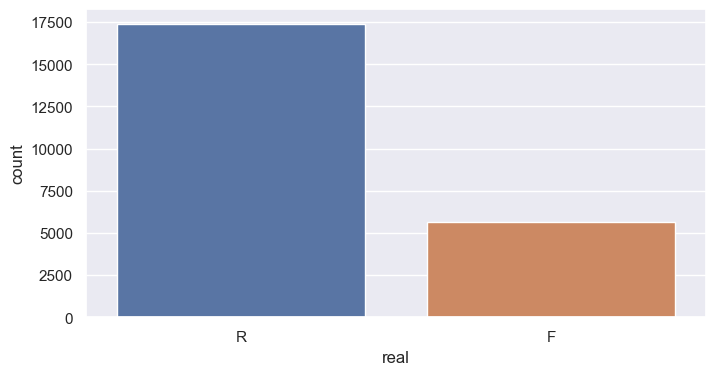

In [87]:
print("The total observations :", len(y.index))

sns.set()
plt.figure(figsize = (8, 4))
sns.countplot(x = y)
plt.show()

## ADASYN

In [90]:
ad = ADASYN()
x_ad, y_ad = ad.fit_resample(x, y)

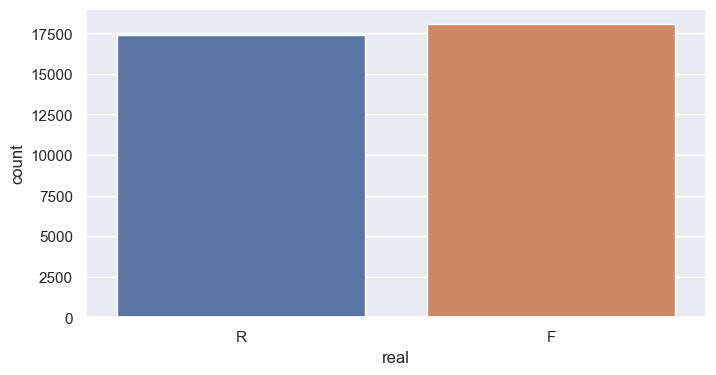

In [91]:
sns.set()
plt.figure(figsize = (8, 4))
sns.countplot(x = y_ad)
plt.show()

## RandomOverSampler

In [92]:
ros = RandomOverSampler()
x_ros, y_ros = ros.fit_resample(x, y)

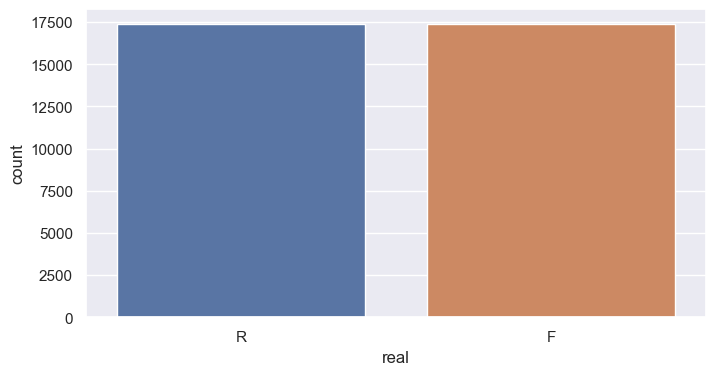

In [93]:
sns.set()
plt.figure(figsize = (8, 4))
sns.countplot(x = y_ros)
plt.show()

## SMOTE

In [94]:
sm = SMOTE()
x_sm, y_sm = sm.fit_resample(x, y)

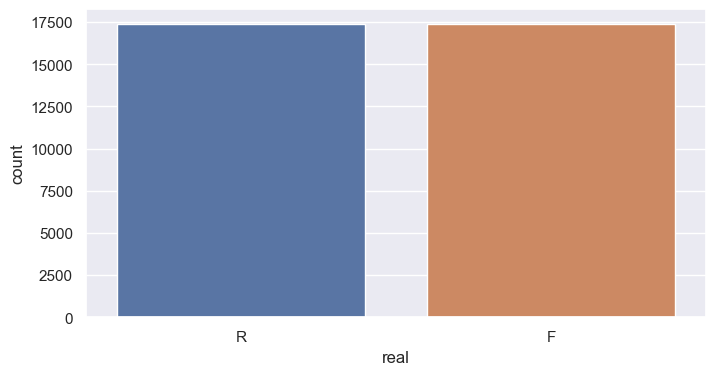

In [95]:
sns.set()
plt.figure(figsize = (8, 4))
sns.countplot(x = y_sm)
plt.show()

# Model building.

In [96]:
def func(x, y):

    algorithms = {
        
        'LogisticRegression' : {
            'model': LogisticRegression(),
            'param_grid' : {
                'penalty': ['l1', 'l2'],              
                'C': [0.001, 0.01, 0.1, 1, 10],        
                'solver': ['liblinear', 'saga'],        
                }
            },
        
        'KNeighborsClassifier': {
            'model': KNeighborsClassifier(),
            'param_grid' : {
                'n_neighbors': [3, 5, 7],         
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree'],  
                'p': [1, 2]                         
                }
        },
        
        'DecisionTreeClassifier': {
            'model': DecisionTreeClassifier(),
            'param_grid' : {
                'criterion': ['gini', 'entropy'],           
                'splitter': ['best', 'random'],          
                'max_depth': [None, 5, 10, 20]         
                }
        },
        
        'RandomForestClassifier' : {
            'model' : RandomForestClassifier(),
            'param_grid' : {
                'n_estimators': [100, 200, 500],         
                'criterion': ['gini', 'entropy'],          
                'min_samples_leaf': [1, 2, 4]
            }
        },
    
        'ExtraTreesClassifier' : {
            'model' : ExtraTreesClassifier(),
            'param_grid' : {
                'n_estimators': [100, 200, 500],         
                'criterion': ['gini', 'entropy'],          
                'max_depth': [None, 5, 10, 20]
            }
        },
    
        'SVC' : {
            'model' : SVC(),
            'param_grid' : {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'poly', 'rbf'],
                'gamma': ['scale', 'auto', 0.1, 1]
            }
        }
    }
    
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    a = []
    b = []
    c = []

    for i, j in algorithms.items():
        print(i, "Algorithm")
        gsc =  GridSearchCV(j['model'], j['param_grid'], cv=cv)
        gsc.fit(x, y)
        best_param = gsc.best_params_
        best_score = gsc.best_score_
        

        a.append(best_param)
        b.append(best_score)
        c.append(i)
        
        y_pred = gsc.predict(x)

        print("\n classification report :")
        print(classification_report(y, y_pred))

        sns.set()
        sns.heatmap(confusion_matrix(y, y_pred), annot = True, linewidths = 0.6, cmap = "coolwarm_r", fmt = 'g')
        plt.show()
        print("\n \n")
        
    d = pd.DataFrame({"Algorith" : c, "Best parameter" : a, "Best score" : b})
        
    return d